# ECE2795 Reinforcement Learning

## Homework Assignment 2

## Total: 100 puntos

In [1]:
# Paquetes a importar
import copy
import random
import numpy as np
from IPython.display import Image
from matplotlib import pyplot as plt
import math




# 1) Actor-Critic for the Continuous Mountain Car Problem (50p)



#### Setup

In [57]:
# Continuous Mountain Car environment

"""
@author: Olivier Sigaud

A merge between two sources:

* Adaptation of the MountainCar Environment from the "FAReinforcement" library
of Jose Antonio Martin H. (version 1.0), adapted by  'Tom Schaul, tom@idsia.ch'
and then modified by Arnaud de Broissia

* the OpenAI/gym MountainCar environment
itself from https://perma.cc/6Z2N-PFWC
"""

class Continuous_MountainCarEnv:
  def __init__(self, goal_velocity = 0):
    self.min_action = -1.0
    self.max_action = 1.0
    self.min_position = -1.2
    self.max_position = 0.6
    self.max_speed = 0.07
    self.goal_position = 0.45 # was 0.5 in gym, 0.45 in Arnaud de Broissia's version
    self.goal_velocity = goal_velocity
    self.power = 0.0015

    self.low_state = np.array([self.min_position, -self.max_speed])
    self.high_state = np.array([self.max_position, self.max_speed])

    self.seed()
    self.reset()

  def seed(self, seed=None):
      np.random.seed(seed)

  def step(self, action):

    position = self.state[0]
    velocity = self.state[1]
    force = min(max(action[0], -1.0), 1.0)

    velocity += force*self.power -0.0025 * math.cos(3*position)
    if (velocity > self.max_speed): velocity = self.max_speed
    if (velocity < -self.max_speed): velocity = -self.max_speed
    position += velocity
    if (position > self.max_position): position = self.max_position
    if (position < self.min_position): position = self.min_position
    if (position==self.min_position and velocity<0): velocity = 0

    done = bool(position >= self.goal_position and velocity >= self.goal_velocity)

    reward = 0
    if done:
      reward = 100.0
    try:
      reward-= math.pow(force,2)*0.1
    except:
      print('EXCEPTION: step action=', action[0])
    self.state = np.array([position, velocity])
    return self.state, reward, done

  def reset(self):
      self.state = np.array([np.random.uniform(low=-0.6, high=-0.4), 0])
      return np.array(self.state)

  def print(self):
      print(self.state)

In [58]:
class LinearPolicy(object):
    def __init__(self, num_states, num_actions, sigma, learning_rate):
        self.num_states = num_states
        self.num_actions = num_actions
        self.weights = np.zeros((self.num_states, self.num_actions)) # podes cambiar esta inicializacion
        self.sigma = sigma
        self.learning_rate = learning_rate

    def compute_gaussian(self, state, action):
        mu = self.getmu(state)
        return 1/(self.sigma * np.sqrt(2 * np.pi)) * np.exp(-(action - mu))

    # gets the inner product of the indexing function and weights
    def getmu(self, state):
        b = np.transpose(self.getb(state))
        return np.inner(b, np.transpose(self.weights))

    # gets indexing function b
    def getb(self, state):
        # print(state)
        b = np.zeros([self.num_states,1])
        pos = state[0]
        vel = state[1]
        if pos < 0 and vel < 0:
            b[0] = 1
        elif pos < 0 and vel > 0:
            b[1] = 1
        elif pos > 0 and vel < 0:
            b[2] = 1
        elif pos > 0 and vel > 0:
            b[3] = 1
        return b

  # output: action acording to the policy
    def act(self, state, action=1):
        return self.compute_gaussian(state, action)

    # TAREA: fill this routine
    # output: numpy.array of dimensions (self.num_states, self.num_actions)
    def compute_gradient(self, state, action):
        b = self.getb(state)
        gradient = -1 / (pow(self.sigma, 2)) * (action - self.getmu(state))*b
        return gradient

  # updates the policy with a gradient step
    def update(self, state, action, I, advantage):
        grad = self.compute_gradient(state, action)
        weights = self.learning_rate*I*advantage*grad
        self.weights += weights

In [59]:
class LinearValue:
    def __init__(self, num_states, num_actions, learning_rate):
        self.num_states = num_states
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.weights = np.zeros([num_states])

    def getb(self, state):
        # print(state)
        b = np.zeros([self.num_states,1])
        pos = state[0]
        vel = state[1]
        if pos <= 0 and vel <= 0:
            b[0] = 1
        elif pos <= 0 and vel > 0:
            b[1] = 1
        elif pos > 0 and vel <= 0:
            b[2] = 1
        elif pos > 0 and vel > 0:
            b[3] = 1
        index = np.where(b == 1)[0]
        return index

    def predict(self, state):
        state_index = self.getb(state)
        return self.weights[state_index]

    def update(self, advantage, state):
        state_index = self.getb(state)
        #UPDATE THE WEIGHTS OF THE VALUE FUNCTION
        self.weights[state_index] += self.learning_rate*advantage*1

In [60]:
def actor_critic(env,policy,value,gamma, num_episodes):
    reward_hist = []
    x_plot = []
    for ep in range(num_episodes):
        if ep%100 == 0:
            print(ep)
        I = 1
        state = env.reset()
        done = False

        rew_list = []
        ep_len = 0
        while not done:
            action = policy.act(state)
            next_state, reward, done = env.step(action)
            rew_list.append(reward)
            # calculate advantage
            adv = reward + gamma*value.predict(next_state) - value.predict(state)
            # update things
            value.update(adv, state)
            policy.update(state, action, I, adv)

            I *= gamma
            state = next_state
            ep_len += 1
            if ep_len > 100:
                done = True
        x_plot.append(state[0])
        reward_hist.append(np.sum(rew_list))
    return reward_hist, x_plot

0


C:\Users\ereij\AppData\Local\Temp\ipykernel_21264\4036819427.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward-= math.pow(force,2)*0.1
C:\Users\ereij\AppData\Local\Temp\ipykernel_21264\4036819427.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  velocity += force*self.power -0.0025 * math.cos(3*position)


100
200
300
400
500
600
700
800
900


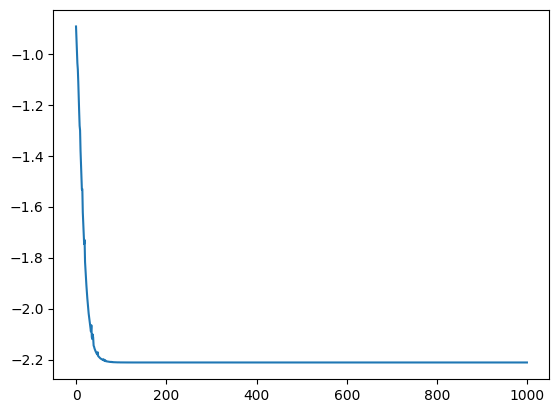

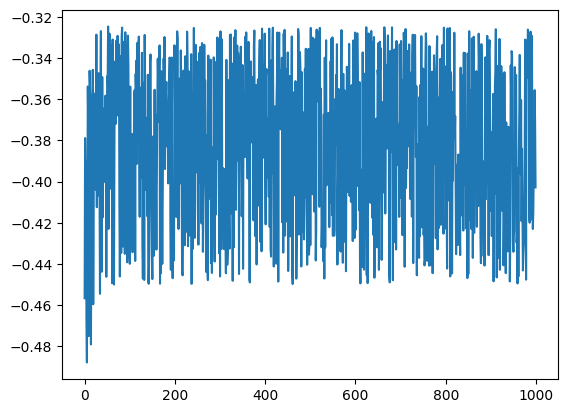

C:\Users\ereij\AppData\Local\Temp\ipykernel_21264\666791362.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value_plot[pos_idx, vel_idx] = value.predict([pos_plot[pos_idx], vel_plot[vel_idx]])
C:\Users\ereij\AppData\Local\Temp\ipykernel_21264\666791362.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q_plotpos[pos_idx, vel_idx] = policy.act([pos_plot[pos_idx], vel_plot[vel_idx]], -1)*(discount*value_plot[pos_idx, vel_idx])


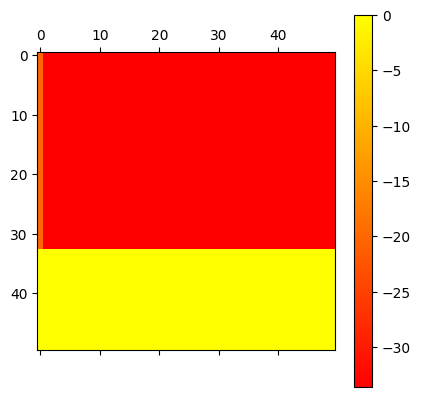

In [64]:
learning_rate_policy=0.05
learning_rate_value=0.01
noise_sigma=0.5
discount=0.999
num_episodes=1000
env=Continuous_MountainCarEnv()
policy=LinearPolicy(4,1,noise_sigma, learning_rate_policy)
value=LinearValue(4,1,learning_rate_value)
reward_hist, x_plot = actor_critic(env,policy,value,discount,num_episodes)

plt.plot(range(num_episodes), reward_hist)
# plt.savefig('im2_1_rew_bigep.png')
plt.show()
plt.plot(range(num_episodes), x_plot)
plt.savefig('im1_3_X.png')
plt.show()

# min_position = -1.2
# max_position = 0.6
# max_speed = 0.07

# calculate value matrix
pos_plot = np.linspace(-1.2, .6, 50)
vel_plot = np.linspace(0, .07, 50)
value_plot = np.zeros([50,50])
q_plotpos = np.zeros([50,50])
q_plotneg = np.zeros([50,50])
for pos_idx in range(len(pos_plot)):
    for vel_idx in range(len(vel_plot)):
        value_plot[pos_idx, vel_idx] = value.predict([pos_plot[pos_idx], vel_plot[vel_idx]])
        q_plotpos[pos_idx, vel_idx] = policy.act([pos_plot[pos_idx], vel_plot[vel_idx]], -1)*(discount*value_plot[pos_idx, vel_idx])

plt.matshow(q_plotpos, cmap='autumn')
plt.colorbar()
plt.savefig('im1_qneg.png')
plt.show()

## 1.3 Results
![Pr1.3](im1_3_X.png)
## 1.4 Results & Discussion
![Pr1.4](im1_valueplot.png)
The graph did not converge on a successful result. Instead, it converged somewhere slightly behind the initial starting area
## 1.5 Results
![Pr1.5pos](im1_qpos.png)
![Pr1.5neg](im1_qneg.png)
#3 1.6 Discussion
Between this and REINFORCE, Actor-Critic is slower because it employs both a policy-iteration AND value-iteration to approach an optimal policy. This means it requires more operations per episode than REINFORCE, however the tradeoff is that it has global convergence.


# Problem 2 Q-Learning
## Grid-world setup

In [34]:
import numpy as np
import copy

MAP1 = ["s0",
        "0g"]

MAP2 = ["s0100",
        "00100",
        "00100",
        "00000",
        "0000g"]

MAP3 = ["s0100000",
        "00100000",
        "00100100",
        "00100100",
        "00000100",
        "0000010g"]

MAP4 = ["s0100001g0000",
        "0010000111100",
        "0010010100000",
        "0010010101000",
        "0000010101001",
        "0000010001000"]

class GridWorld(object):
    EMPTY = 0
    HOLE = 1
    START = 2
    GOAL = 3

    ACTION_UP = 0
    ACTION_RIGHT = 1
    ACTION_DOWN = 2
    ACTION_LEFT = 3

    def __init__(self, map_string, stochastic=False):
        self._parse_string(map_string)
        self.reset()
        self.max_steps = self.get_num_states()
        self.fall_reward = -100
        self.goal_reward = 100
        self.step_reward = -1
        self.stochastic = stochastic

    def get_num_states(self):
        return self.n_rows * self.n_cols

    def get_num_actions(self):
        return 4

    # Resets the grid world to the starting position
    def reset(self):
        self.loc = copy.deepcopy(self.start)
        self.step_iter = 0
        return self._flatten_idx(self.loc)

    # Takes an action "u", which is one of
    # [GridWorld.ACTION_UP, GridWorld.ACTION_RIGHT, GridWorld.ACTION_DOWN, GridWorld.ACTION_LEFT]
    # this function will return a tuple of
    # (next_state, reward, done)
    # where
    # next state is the state of the system after taking action "u"
    # reward is the one-step reward
    # done is a boolean saying whether or not the episode has ended.
    # if done is true, you have to call reset() before you can call step() again
    def step(self, u):

        stochastic_prob = 0.7
        if self.stochastic:
            if u == GridWorld.ACTION_UP:
                u_new = np.random.choice(
                    [GridWorld.ACTION_UP, GridWorld.ACTION_LEFT, GridWorld.ACTION_RIGHT],
                    p=[stochastic_prob, 0.5*(1-stochastic_prob), 0.5*(1-stochastic_prob)])
            elif u == GridWorld.ACTION_RIGHT:
                u_new = np.random.choice(
                    [GridWorld.ACTION_RIGHT, GridWorld.ACTION_UP, GridWorld.ACTION_DOWN],
                    p=[stochastic_prob, 0.5*(1-stochastic_prob), 0.5*(1-stochastic_prob)])
            elif u == GridWorld.ACTION_DOWN:
                u_new = np.random.choice(
                    [GridWorld.ACTION_DOWN, GridWorld.ACTION_LEFT, GridWorld.ACTION_RIGHT],
                    p=[stochastic_prob, 0.5*(1-stochastic_prob), 0.5*(1-stochastic_prob)])
            elif u == GridWorld.ACTION_LEFT:
                u_new = np.random.choice(
                    [GridWorld.ACTION_LEFT, GridWorld.ACTION_UP, GridWorld.ACTION_DOWN],
                    p=[stochastic_prob, 0.5*(1-stochastic_prob), 0.5*(1-stochastic_prob)])
        else:
            u_new = u

        if u_new == GridWorld.ACTION_UP:
            self.loc[0] -= 1
        elif u_new == GridWorld.ACTION_DOWN:
            self.loc[0] += 1
        elif u_new == GridWorld.ACTION_RIGHT:
            self.loc[1] += 1
        elif u_new == GridWorld.ACTION_LEFT:
            self.loc[1] -= 1
        else:
            raise Exception("Not a valid action")

        out_of_bounds = False
        if self.loc[0] < 0:
            self.loc[0] = 0
            out_of_bounds = True
        if self.loc[0] >= self.n_rows:
            self.loc[0] = self.n_rows - 1
            out_of_bounds = True
        if self.loc[1] < 0:
            self.loc[1] = 0
            out_of_bounds = True
        if self.loc[1] >= self.n_cols:
            self.loc[1] = self.n_cols - 1
            out_of_bounds = True

        self.step_iter += 1


        goal_reached = (self.loc == self.goal)
        if (out_of_bounds):
            return self._flatten_idx(self.loc), self.fall_reward, True
        if self.map[self.loc[0], self.loc[1]] == GridWorld.HOLE:
            return self._flatten_idx(self.loc), self.fall_reward, True
        if goal_reached:
            return self._flatten_idx(self.loc), self.goal_reward, True
        if self.step_iter == self.max_steps:
            return self._flatten_idx(self.loc), self.step_reward, True
        return self._flatten_idx(self.loc), self.step_reward, False

    def print(self):
        print_str = ""
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if self.loc == [row, col]:
                    print_str += "*"
                else:
                    print_str += str(self.map[row, col])
            print_str += "\n"
        print(print_str)

    def _flatten_idx(self, idx):
        flattened = idx[0] * self.n_cols + idx[1]
        return flattened

    def _unflatten_idx(self, idx):
        i = int(math.floor(self.loc / self.n_cols))
        j = idx - (i * self.n_cols)
        unflattened = (i, j)
        return unflattened

    def _parse_string(self, map_string):
        assert(len(map_string) > 0)
        assert(len(map_string[0]) > 0)

        self.n_rows = len(map_string)
        self.n_cols = len(map_string[0])

        self.map = np.zeros((self.n_rows, self.n_cols), dtype=np.int8)
        symbol_dict = {
            "0" : GridWorld.EMPTY,
            "1" : GridWorld.HOLE,
            "s" : GridWorld.START,
            "g" : GridWorld.GOAL}

        for row_idx, row in enumerate(map_string):
            assert(len(row) == self.n_cols)
            for col_idx in range(self.n_cols):
                assert(row[col_idx] in symbol_dict.keys())
                self.map[row_idx, col_idx] = symbol_dict[row[col_idx]]
                if row[col_idx] == 's':
                    self.start = [row_idx, col_idx]
                if row[col_idx] == 'g':
                    self.goal = [row_idx, col_idx]

In [35]:
def EpsilonGreedyPolicy(q, eps, state):
    """
    Implement epsilon-greedy policy.

    Given a table (q), a state (state) and a probability (eps),
    it returns an integer between 0 y 3 representing the action.
    """
    sample = np.random.random_sample()
    num_actions = q.shape[1]
    if sample < eps:
        # random action
        action = random.randint(0, num_actions-1)
    else:
        # max q[state]
        m = np.max(q[state])
        indices = np.where(q[state] == m)[0]
        action = np.random.choice(indices)
    # print(action)
    return action

def QMap(q, len, wid):
    qmap = np.zeros(shape=[len, wid])
    qmax = np.zeros(shape=[len*wid])
    for state in range(len*wid):
        qmax = np.max(q[state])
        idx = np.unravel_index(state, [len, wid])
        qmap[idx] = qmax

    return qmap

class TabularTD(object):
  """
  Implements a Q-learning agent.

    """
  def __init__(self, num_states, num_actions, gamma=0.95, alpha=0.5):
      self.num_states = num_states
      self.num_actions = num_actions
      self.alpha = alpha
      self.gamma = gamma
      self.reset()

  def reset(self):
    self.Q = np.zeros((self.num_states, self.num_actions))
    return


  def update(self, state, action, reward, next_state, done):
    self.Q[state, action] += self.alpha*(reward + self.gamma*np.max(self.Q[next_state]) - self.Q[state, action])
    return

## 2.2) Experiments

0
42


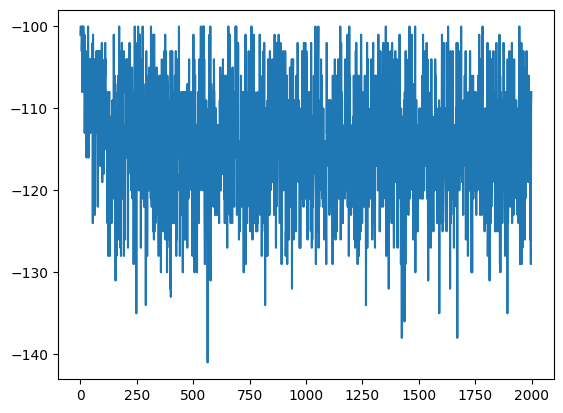

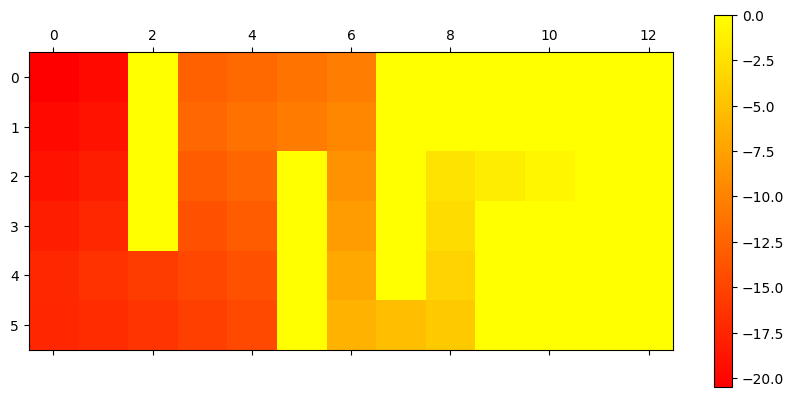

In [52]:
def dynamicEpsilon(curr_ep, max_ep):
    return (curr_ep)/(max_ep)

# env = GridWorld(MAP1)
env = GridWorld(MAP4)
gamma = .99
alpha = .3
eps = .01

qlearning = TabularTD(env.get_num_states(), env.get_num_actions(),
                      alpha=alpha, gamma=gamma)

reward_hist = []
s0_return = []

num_episodes = int(2000)
max_ep_len = 1
for i in range(num_episodes):
    if i%10000 == 0:
        print(i)
    state = env.reset()
    done = False

    reward_list = []

    action = EpsilonGreedyPolicy(qlearning.Q, eps, state)
    s0_return.append(qlearning.Q[state, action])
    ep_len = 0
    while not done:
        ep_len += 1
        action = EpsilonGreedyPolicy(qlearning.Q, dynamicEpsilon(ep_len, max_ep_len), state)
        # action = EpsilonGreedyPolicy(qlearning.Q, eps, state)
        next_state, reward, done = env.step(action)
        reward_list.append(reward)
        qlearning.update(state, action, reward, next_state, done)
        state = next_state
    if ep_len > max_ep_len:
        max_ep_len = ep_len
    reward_hist.append(np.sum(reward_list))

print(max_ep_len)
#TODO: PLOT RESULTS
# plt.plot(range(num_episodes)[num_episodes-1000:], reward_hist[num_episodes-1000:])
plt.plot(range(num_episodes), reward_hist)
plt.savefig('im2_dynamic_plot.png')
plt.show()

# # plot optimal q start for MAP2
# plt.plot(range(num_episodes), s0_return)
# plt.axhline(y=86.4, color='r', linestyle='-')
# plt.savefig('im2_2_s0.png')
# plt.show()
# print(len(MAP1), len(MAP1[0]))
plt.matshow(QMap(qlearning.Q, len(MAP4), len(MAP4[0])), cmap='autumn')
plt.colorbar()
# plt.savefig('im2_staticeps.png')
plt.show()


## 2.1 Results
#### Results with epsilon = 0.001
![Pr2.1 rew_smallep](im2_1_rew_smallep.png)
![Pr2.1 smallep](im2_1_smallep.png)<br>
#### Results with epsilon = 0.1
![Pr2.1 rew_bigep](im2_1_rew_bigep.png)
![Pr2.1 bigep](im2_1_bigep.png)<br>
### Discussion
The performance of the greedy policy is mainly determined by the epsilon chosen. Choosing a small epsilon (0.001) creates a very clean path from the start to goal and converges very quickly to reaching the goal consistently. Choosing a large epsilon creates a more complete path from the start to goal and doesn't converge as quickly or consistently to the goal.<br>
## 2.2 Results
Parameters:
gamma = .99
alpha = .3
eps = .001
<br> Optimal Q* for start state = 86.4 <br>
![Pr2.2 s0](im2_2_s0.png)
<br> The model converges around 75 episodes <br>
The model can still perform well with a suboptimal Q value for the initial state for two reasons. First, there are 2 valid moves for the agent to take, so not taking the most optimal action can still result in a successful episode. Second, with an epsilon greedy policy, suboptimal Q values may still be the maximum value action, and there's always a chance to take a random action.
## 2.3 Results
### Parameters
gamma = .99
alpha = .5
eps = .001
### T = 0
![Pr2.3 0](im2_3_0.png)
### T = 10
![Pr2.3 10](im2_3_10.png)
### T = 100
![Pr2.3 100](im2_3_100.png)
### T = 500
![Pr2.3 500](im2_3_500.png)
### T = 1000
![Pr2.3 1000](im2_3_1000.png)
## 2.4 Discussion
Q-Learning Differs from Value Iteration because Q-Learning does not require full knowledge of the environment in order to find a best policy. Value iteration does not this information, so it is not a learning algorithm but a planning algorithm
## Q-Learning Discussion
I also messed around with a dynamically changing epsilon such that it promotes exploitation earlier in an episode and exploration later in an episode. This works by computing the ratio of the current time step in the episode to the maximum length episode seen thus far. My hope was that this would converge faster as it wouldn't waste time on the already solved path. However, it takes more time to converge because it initially has a high epsilon since the maximum episode is close to 1. This causes high initial noise, that delays convergence until a randomly long episode occurs.
#### Static Epsilon Result after 2000 Episodes
![Pr2_static_plot](im2_static_plot.png)
![Pr2_staticeps](im2_staticeps.png)
#### Dynamic Epsilon Result after 2000 Episodes
![Pr2_dynamic_plot](im2_dynamic_plot.png)
![Pr2_dynamiceps](im2_dynamiceps.png)